# Treasure Hunt Game Notebook

## Read and Review Your Starter Code
The theme of this project is a popular treasure hunt game in which the player needs to find the treasure before the pirate does. While you will not be developing the entire game, you will write the part of the game that represents the intelligent agent, which is a pirate in this case. The pirate will try to find the optimal path to the treasure using deep Q-learning. 

You have been provided with two Python classes and this notebook to help you with this assignment. The first class, TreasureMaze.py, represents the environment, which includes a maze object defined as a matrix. The second class, GameExperience.py, stores the episodes – that is, all the states that come in between the initial state and the terminal state. This is later used by the agent for learning by experience, called "exploration". This notebook shows how to play a game. Your task is to complete the deep Q-learning implementation for which a skeleton implementation has been provided. The code blocks you will need to complete has #TODO as a header.

First, read and review the next few code and instruction blocks to understand the code that you have been given.

In [2]:
from __future__ import print_function
import os, sys, time, datetime, json, random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, PReLU
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from TreasureMaze import TreasureMaze
from GameExperience import GameExperience
%matplotlib inline

The following code block contains an 8x8 matrix that will be used as a maze object:

In [2]:
maze = np.array([
    [ 1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  0.,  1.,  1.,  1.,  0.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  0.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  0.,  0.,  0.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.]
])

This helper function allows a visual representation of the maze object:

In [3]:
def show(qmaze):
    plt.grid('on')
    nrows, ncols = qmaze.maze.shape
    ax = plt.gca()
    ax.set_xticks(np.arange(0.5, nrows, 1))
    ax.set_yticks(np.arange(0.5, ncols, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    canvas = np.copy(qmaze.maze)
    for row,col in qmaze.visited:
        canvas[row,col] = 0.6
    pirate_row, pirate_col, _ = qmaze.state
    canvas[pirate_row, pirate_col] = 0.3   # pirate cell
    canvas[nrows-1, ncols-1] = 0.9 # treasure cell
    img = plt.imshow(canvas, interpolation='none', cmap='gray')
    return img

The pirate agent can move in four directions: left, right, up, and down. 

While the agent primarily learns by experience through exploitation, often, the agent can choose to explore the environment to find previously undiscovered paths. This is called "exploration" and is defined by epsilon. This value is typically a lower value such as 0.1, which means for every ten attempts, the agent will attempt to learn by experience nine times and will randomly explore a new path one time. You are encouraged to try various values for the exploration factor and see how the algorithm performs.

In [4]:
LEFT = 0
UP = 1
RIGHT = 2
DOWN = 3


# Exploration factor
epsilon = 0.1

# Actions dictionary
actions_dict = {
    LEFT: 'left',
    UP: 'up',
    RIGHT: 'right',
    DOWN: 'down',
}

num_actions = len(actions_dict)


The sample code block and output below show creating a maze object and performing one action (DOWN), which returns the reward. The resulting updated environment is visualized.

reward= -0.04


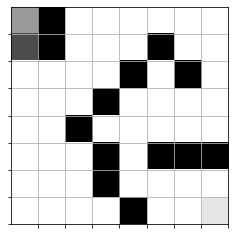

In [5]:
qmaze = TreasureMaze(maze)
canvas, reward, game_over = qmaze.act(DOWN)
print("reward=", reward)
show(qmaze)

This function simulates a full game based on the provided trained model. The other parameters include the TreasureMaze object and the starting position of the pirate.

In [6]:
def play_game(model, qmaze, pirate_cell):
    qmaze.reset(pirate_cell)
    envstate = qmaze.observe()
    while True:
        prev_envstate = envstate
        # get next action
        q = model.predict(prev_envstate)
        action = np.argmax(q[0])

        # apply action, get rewards and new state
        envstate, reward, game_status = qmaze.act(action)
        if game_status == 'win':
            return True
        elif game_status == 'lose':
            return False

This function helps you to determine whether the pirate can win any game at all. If your maze is not well designed, the pirate may not win any game at all. In this case, your training would not yield any result. The provided maze in this notebook ensures that there is a path to win and you can run this method to check.

In [7]:
def completion_check(model, qmaze):
    for cell in qmaze.free_cells:
        if not qmaze.valid_actions(cell):
            return False
        if not play_game(model, qmaze, cell):
            return False
    return True

The code you have been given in this block will build the neural network model. Review the code and note the number of layers, as well as the activation, optimizer, and loss functions that are used to train the model.

In [8]:
def build_model(maze):
    model = Sequential()
    model.add(Dense(maze.size, input_shape=(maze.size,)))
    model.add(PReLU())
    model.add(Dense(maze.size))
    model.add(PReLU())
    model.add(Dense(num_actions))
    model.compile(optimizer='adam', loss='mse')
    return model

# #TODO: Complete the Q-Training Algorithm Code Block

This is your deep Q-learning implementation. The goal of your deep Q-learning implementation is to find the best possible navigation sequence that results in reaching the treasure cell while maximizing the reward. In your implementation, you need to determine the optimal number of epochs to achieve a 100% win rate.

You will need to complete the section starting with #pseudocode. The pseudocode has been included for you.

In [ ]:
"""
===============================================================
CS-499 Capstone – Algorithms and Data Structures Enhancement
Author: Amos Roland

Purpose:
This enhanced Q-learning algorithm demonstrates my skills in
algorithm design, optimization, and data structure usage.
The improvements help the agent converge more efficiently and
use replay memory in a structured way. The documentation also
explains time complexity and algorithmic reasoning in simple terms.

Key Enhancements:
1. Epsilon Adjustment:
- Exploration is reduced once the agent maintains a high win rate.
- This encourages more stable learning after performance improves.

2. Replay Memory Optimization:
- Efficient batch updates drawn from the replay buffer.
- Replay buffer operates like a bounded queue (O(1) amortized inserts).

3. Training Efficiency Controls:
- 'warmup_steps' allows the replay memory to fill before training.
- 'train_every' reduces the number of model updates for faster runtime.

4. Time Complexity Notes:
    Training Loop: O(n_epoch * steps_per_game)
-   Predict Operation: O(model_complexity)
-   Mini-batch Assembly: O(data_size)
===============================================================
"""



def qtrain(model, maze, **opt):
    # Train a Deep Q learning agent on the treasure maze.
    # This supports my CS 499 enhancement by showing how I use
    # an epsilon greedy policy, a replay buffer, and a monitored
    # training loop to improve performance over time.

    global epsilon

    # Number of training epochs.
    # If not provided in opt, a default value is used.
    n_epoch = opt.get('n_epoch', 15000)

    # Maximum number of experience entries stored in replay memory.
    # This controls how much past data the agent can learn from.
    max_memory = opt.get('max_memory', 1000)

    # Maximum size of a mini batch pulled from replay memory for training.
    # This affects the cost per update and how much data is seen each step.
    data_size = opt.get('data_size', 50)
    
    # train_every:
    #   - Number of environment steps between training updates.
    #   - Larger values = fewer model.fit() calls = faster wall time.
    # warmup_steps:
    #   - Number of initial steps used only to fill replay memory.
    #   - Helps stabilize training and also reduces early overhead.
    train_every = opt.get('train_every', 4)
    warmup_steps = opt.get('warmup_steps', 1000)
    

    # Record the start time so I can measure how long training takes.
    start_time = datetime.datetime.now()
    # Track previous epoch's timestamp so I can compute per-epoch time.
    prev_time = start_time

    # Build the maze environment from the numpy array.
    # This object tracks the state, valid actions, and rewards.
    qmaze = TreasureMaze(maze)

    # Create the experience replay object.
    # Internally this works like a bounded buffer that stores
    # (state, action, reward, next_state, status) transitions.
    experience = GameExperience(model, max_memory=max_memory)

    # Track game outcomes across training.
    # I record 1 for a win and 0 for a loss so I can compute a win rate.
    win_history = []

    # Size of the recent history window used for win rate calculations.
    hsize = qmaze.maze.size//2

    # Store the current win rate for reporting and stopping conditions.
    win_rate = 0.0 
    
    # Initialize global step counter.
    global_step = 0

    # Main training loop across epochs.
    for epoch in range(n_epoch):
        # Reset metrics that belong to this epoch.
        loss = 0.0
        game_over = False
        n_episodes = 0
        
        # Choose a random free cell as the starting position for the agent.
        Agent_cell = random.choice(qmaze.free_cells)

        # Reset the maze so the agent starts from the selected position.
        qmaze.reset(Agent_cell)
        
        # Observe the current environment state as the model input.
        envstate = qmaze.observe()
        
        # Play one episode until the game is over.
        while not game_over:
            # Get all valid actions from the current state.
            valid_actions = qmaze.valid_actions()

            # If there are no valid moves, stop this episode.
            if not valid_actions:
                break 

            # Keep a copy of the previous state for the replay memory.
            prev_envstate = envstate
            
            # Choose an action using epsilon greedy strategy.
            # With probability epsilon the agent explores.
            # Otherwise it exploits the model prediction.
            if np.random.rand() < epsilon:
                action = random.choice(valid_actions)
            else:
                action = np.argmax(experience.predict(prev_envstate))
                            
            # Apply the action in the environment and observe the result.
            envstate, reward, game_status = qmaze.act(action)

            # Record outcome when the game ends.
            if game_status == 'win':
                win_history.append(1)
                game_over = True 
            elif game_status == 'lose':
                win_history.append(0) 
                game_over = True  
            else:
                game_over = False
        
            # Store this transition in the replay memory.
            # Each entry is a small data structure that links state,
            # action, reward, next_state, and game status.
            episode = [prev_envstate, action, reward, envstate, game_status]
            n_episodes += 1 
            experience.remember(episode)

            # Advance the global step counter.
            global_step += 1

            # This reduces the number of model.fit() calls and makes
            # training significantly faster while still using replay.
            if (global_step > warmup_steps and
                len(experience.memory) >= data_size and
                global_step % train_every == 0):

                # Sample a mini batch from replay memory and train the model.
                # This reduces correlation in the data and improves stability.
                inputs, targets = experience.get_data(data_size=data_size)
                History = model.fit(
                    inputs,
                    targets,
                    epochs=1,
                    batch_size=32,
                    verbose=0
                )

                # Track loss on this mini batch to monitor learning progress.
                loss = History.history['loss'][-1]

            
        # After the episode finishes, compute win rate over recent games.
        if len(win_history) > hsize:
            win_rate = sum(win_history[-hsize:]) / hsize
        
        # Print training progress for this epoch.
        dt = datetime.datetime.now() - start_time
        t = format_time(dt.total_seconds())
        template = "Epoch: {:03d}/{:d} | Loss: {:.4f} | Episodes: {:d} | Win count: {:d} | Win rate: {:.3f} | time: {}"
        print(template.format(epoch, n_epoch-1, loss, n_episodes, sum(win_history), win_rate, t)) 
        
        # If the agent is winning most recent games, reduce exploration.
        # Setting epsilon to a small value keeps some exploration while
        # letting the agent rely mainly on what it has learned.
        if win_rate > 0.9 : 
            epsilon = 0.05
        
        # Early stop when recent games are all wins and the model passes
        # the completion check across all free cells.
        if sum(win_history[-hsize:]) == hsize and completion_check(model, qmaze):
            print("Reached 100%% win rate at epoch: %d" % (epoch,)) 
            break 
    
    # Compute total training time in seconds.
    dt = datetime.datetime.now() - start_time 
    seconds = dt.total_seconds() 
    t = format_time(seconds)  
    
    # Print a final summary of training settings and time.
    print("n_epoch: %d, max_mem: %d, data: %d, time: %s" % (epoch, max_memory, data_size, t)) 
    return seconds 


# Utility function for formatting elapsed time into a readable string.
def format_time(seconds):
    # If the duration is short, show it in seconds.
    if seconds < 400:
        s = float(seconds)
        return "%.1f seconds" % (s,) 
    # For medium values, show time in minutes.
    elif seconds < 4000: 
        m = seconds / 60.0
        return "%.2f minutes" % (m,) 
    # For longer runs, show time in hours.
    else:  
        h = seconds / 3600.0
        return "%.2f hours" % (h,)


## Test Your Model

Now we will start testing the deep Q-learning implementation. To begin, select **Cell**, then **Run All** from the menu bar. This will run your notebook. As it runs, you should see output begin to appear beneath the next few cells. The code below creates an instance of TreasureMaze.

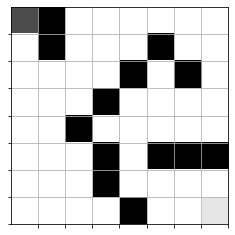

In [10]:
qmaze = TreasureMaze(maze)
show(qmaze)

In the next code block, you will build your model and train it using deep Q-learning. Note: This step takes several minutes to fully run.

In [11]:
model = build_model(maze)
qtrain(model, maze, epochs=1000, max_memory=8*maze.size, data_size=32)

32/32 [==============================] - 0s 31us/step
Epoch: 000/14999 | Loss: 0.0005 | Episodes: 148 | Win count: 0 | Win rate: 0.000 | time: 23.7 seconds
32/32 [==============================] - 0s 0us/step


32/32 [==============================] - 0s 0us/step
Epoch: 001/14999 | Loss: 0.0007 | Episodes: 51 | Win count: 1 | Win rate: 0.500 | time: 29.4 seconds
32/32 [==============================] - 0s 31us/step
Epoch: 002/14999 | Loss: 0.0109 | Episodes: 19 | Win count: 2 | Win rate: 0.667 | time: 31.6 seconds
32/32 [==============================] - 0s 0us/step


32/32 [==============================] - 0s 0us/step
Epoch: 003/14999 | Loss: 0.0047 | Episodes: 145 | Win count: 2 | Win rate: 0.500 | time: 47.9 seconds
32/32 [==============================] - 0s 0us/step
Epoch: 004/14999 | Loss: 0.0008 | Episodes: 72 | Win count: 3 | Win rate: 0.600 | time: 55.9 seconds
32/32 [==============================] - 0s 489us/step


32/32 [==============================] - 0s 0us/step
Epoch: 005/14999 | Loss: 0.0007 | Episodes: 41 | Win count: 4 | Win rate: 0.667 | time: 61.3 seconds
32/32 [==============================] - 0s 0us/step
Epoch: 006/14999 | Loss: 0.0011 | Episodes: 1 | Win count: 5 | Win rate: 0.714 | time: 61.5 seconds
32/32 [==============================] - 0s 0us/step
Epoch: 007/14999 | Loss: 0.0008 | Episodes: 1 | Win count: 6 | Win rate: 0.750 | time: 61.7 seconds
32/32 [==============================] - 0s 0us/step
Epoch: 008/14999 | Loss: 0.0008 | Episodes: 41 | Win count: 7 | Win rate: 0.778 | time: 66.4 seconds
32/32 [==============================] - 0s 0us/step
Epoch: 009/14999 | Loss: 0.0007 | Episodes: 23 | Win count: 8 | Win rate: 0.800 | time: 68.9 seconds
32/32 [==============================] - 0s 0us/step
Epoch: 010/14999 | Loss: 0.0006 | Episodes: 7 | Win count: 9 | Win rate: 0.818 | time: 69.6 seconds
32/32 [==============================] - 0s 0us/step
Epoch: 011/14999 | Loss: 0

32/32 [==============================] - 0s 0us/step
Epoch: 013/14999 | Loss: 0.0010 | Episodes: 25 | Win count: 12 | Win rate: 0.857 | time: 76.1 seconds
32/32 [==============================] - 0s 0us/step
Epoch: 014/14999 | Loss: 0.0006 | Episodes: 24 | Win count: 13 | Win rate: 0.867 | time: 79.0 seconds
32/32 [==============================] - 0s 0us/step
Epoch: 015/14999 | Loss: 0.0011 | Episodes: 28 | Win count: 14 | Win rate: 0.875 | time: 82.1 seconds
32/32 [==============================] - 0s 0us/step
Epoch: 016/14999 | Loss: 0.0007 | Episodes: 12 | Win count: 15 | Win rate: 0.882 | time: 83.4 seconds
32/32 [==============================] - 0s 0us/step
Epoch: 017/14999 | Loss: 0.0010 | Episodes: 44 | Win count: 16 | Win rate: 0.889 | time: 88.6 seconds
32/32 [==============================] - 0s 0us/step


32/32 [==============================] - 0s 32us/step
Epoch: 018/14999 | Loss: 0.0002 | Episodes: 136 | Win count: 16 | Win rate: 0.842 | time: 104.4 seconds
32/32 [==============================] - 0s 31us/step
Epoch: 019/14999 | Loss: 0.0007 | Episodes: 19 | Win count: 17 | Win rate: 0.850 | time: 106.5 seconds
32/32 [==============================] - 0s 0us/step


32/32 [==============================] - 0s 0us/step
Epoch: 020/14999 | Loss: 0.0010 | Episodes: 108 | Win count: 18 | Win rate: 0.857 | time: 118.8 seconds
32/32 [==============================] - 0s 0us/step
Epoch: 021/14999 | Loss: 0.0004 | Episodes: 33 | Win count: 19 | Win rate: 0.864 | time: 122.9 seconds
32/32 [==============================] - 0s 62us/step
Epoch: 022/14999 | Loss: 0.0005 | Episodes: 23 | Win count: 20 | Win rate: 0.870 | time: 125.5 seconds


32/32 [==============================] - 0s 32us/step
Epoch: 023/14999 | Loss: 0.0010 | Episodes: 64 | Win count: 21 | Win rate: 0.875 | time: 132.4 seconds
32/32 [==============================] - 0s 0us/step
Epoch: 024/14999 | Loss: 0.0007 | Episodes: 14 | Win count: 22 | Win rate: 0.880 | time: 134.3 seconds
32/32 [==============================] - 0s 0us/step
Epoch: 025/14999 | Loss: 0.0005 | Episodes: 40 | Win count: 23 | Win rate: 0.885 | time: 139.1 seconds
32/32 [==============================] - 0s 33us/step
Epoch: 026/14999 | Loss: 0.0006 | Episodes: 8 | Win count: 24 | Win rate: 0.889 | time: 140.1 seconds
32/32 [==============================] - 0s 0us/step


32/32 [==============================] - 0s 0us/step
Epoch: 027/14999 | Loss: 0.0011 | Episodes: 25 | Win count: 25 | Win rate: 0.893 | time: 142.8 seconds
32/32 [==============================] - 0s 0us/step
Epoch: 028/14999 | Loss: 0.0008 | Episodes: 9 | Win count: 26 | Win rate: 0.897 | time: 143.7 seconds
32/32 [==============================] - 0s 97us/step
Epoch: 029/14999 | Loss: 0.0005 | Episodes: 1 | Win count: 27 | Win rate: 0.900 | time: 143.9 seconds
32/32 [==============================] - 0s 0us/step
Epoch: 030/14999 | Loss: 0.0003 | Episodes: 28 | Win count: 28 | Win rate: 0.903 | time: 147.1 seconds
32/32 [==============================] - 0s 32us/step
Epoch: 031/14999 | Loss: 0.0006 | Episodes: 25 | Win count: 29 | Win rate: 0.906 | time: 151.0 seconds
32/32 [==============================] - 0s 32us/step
Epoch: 032/14999 | Loss: 0.0009 | Episodes: 7 | Win count: 30 | Win rate: 0.909 | time: 152.0 seconds
32/32 [==============================] - 0s 0us/step


32/32 [==============================] - 0s 0us/step
Epoch: 033/14999 | Loss: 0.0019 | Episodes: 87 | Win count: 31 | Win rate: 0.912 | time: 162.2 seconds
32/32 [==============================] - 0s 0us/step
Epoch: 034/14999 | Loss: 0.0011 | Episodes: 25 | Win count: 32 | Win rate: 0.914 | time: 165.0 seconds
32/32 [==============================] - 0s 30us/step
Epoch: 035/14999 | Loss: 0.0006 | Episodes: 5 | Win count: 33 | Win rate: 0.917 | time: 165.6 seconds
32/32 [==============================] - 0s 503us/step
Epoch: 036/14999 | Loss: 0.0006 | Episodes: 19 | Win count: 34 | Win rate: 0.919 | time: 167.8 seconds
32/32 [==============================] - 0s 0us/step
Epoch: 037/14999 | Loss: 0.0003 | Episodes: 19 | Win count: 35 | Win rate: 0.921 | time: 169.8 seconds
32/32 [==============================] - 0s 0us/step
Epoch: 038/14999 | Loss: 0.0004 | Episodes: 15 | Win count: 36 | Win rate: 0.923 | time: 171.8 seconds
32/32 [==============================] - 0s 0us/step
Epoch: 03

32/32 [==============================] - 0s 0us/step
Epoch: 041/14999 | Loss: 0.0010 | Episodes: 23 | Win count: 39 | Win rate: 0.929 | time: 176.8 seconds
32/32 [==============================] - 0s 61us/step
Epoch: 042/14999 | Loss: 0.0005 | Episodes: 8 | Win count: 40 | Win rate: 0.930 | time: 177.9 seconds
32/32 [==============================] - 0s 0us/step
Epoch: 043/14999 | Loss: 0.0005 | Episodes: 17 | Win count: 41 | Win rate: 0.932 | time: 180.0 seconds
32/32 [==============================] - 0s 0us/step
Epoch: 044/14999 | Loss: 0.0004 | Episodes: 21 | Win count: 42 | Win rate: 0.933 | time: 182.8 seconds
32/32 [==============================] - 0s 0us/step
Epoch: 045/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 43 | Win rate: 0.935 | time: 186.1 seconds
32/32 [==============================] - 0s 0us/step
Epoch: 046/14999 | Loss: 0.0000 | Episodes: 12 | Win count: 44 | Win rate: 0.936 | time: 187.6 seconds
32/32 [==============================] - 0s 33us/step


32/32 [==============================] - 0s 32us/step
Epoch: 047/14999 | Loss: 0.0002 | Episodes: 49 | Win count: 45 | Win rate: 0.938 | time: 193.1 seconds
32/32 [==============================] - 0s 31us/step
Epoch: 048/14999 | Loss: 0.0005 | Episodes: 98 | Win count: 46 | Win rate: 0.939 | time: 204.9 seconds
32/32 [==============================] - 0s 107us/step
Epoch: 049/14999 | Loss: 0.0001 | Episodes: 23 | Win count: 47 | Win rate: 0.940 | time: 208.0 seconds
32/32 [==============================] - 0s 0us/step


32/32 [==============================] - 0s 31us/step
Epoch: 050/14999 | Loss: 0.0005 | Episodes: 31 | Win count: 48 | Win rate: 0.941 | time: 211.9 seconds
32/32 [==============================] - 0s 490us/step
Epoch: 051/14999 | Loss: 0.0007 | Episodes: 26 | Win count: 49 | Win rate: 0.942 | time: 215.3 seconds
32/32 [==============================] - 0s 63us/step
Epoch: 052/14999 | Loss: 0.0006 | Episodes: 1 | Win count: 50 | Win rate: 0.943 | time: 215.9 seconds
32/32 [==============================] - 0s 63us/step
Epoch: 053/14999 | Loss: 0.0001 | Episodes: 15 | Win count: 51 | Win rate: 0.944 | time: 217.9 seconds
32/32 [==============================] - 0s 31us/step
Epoch: 054/14999 | Loss: 0.0001 | Episodes: 25 | Win count: 52 | Win rate: 0.945 | time: 221.3 seconds
32/32 [==============================] - 0s 0us/step
Epoch: 055/14999 | Loss: 0.0004 | Episodes: 24 | Win count: 53 | Win rate: 0.946 | time: 224.4 seconds
32/32 [==============================] - 0s 32us/step
Epoch

32/32 [==============================] - 0s 0us/step
Epoch: 057/14999 | Loss: 0.0001 | Episodes: 33 | Win count: 55 | Win rate: 0.948 | time: 231.0 seconds
32/32 [==============================] - 0s 69us/step
Epoch: 058/14999 | Loss: 0.0002 | Episodes: 22 | Win count: 56 | Win rate: 0.949 | time: 234.0 seconds
32/32 [==============================] - 0s 448us/step
Epoch: 059/14999 | Loss: 0.0008 | Episodes: 8 | Win count: 57 | Win rate: 0.950 | time: 235.2 seconds
32/32 [==============================] - 0s 0us/step
Epoch: 060/14999 | Loss: 0.0004 | Episodes: 1 | Win count: 58 | Win rate: 0.951 | time: 235.6 seconds
32/32 [==============================] - 0s 0us/step
Epoch: 061/14999 | Loss: 0.0003 | Episodes: 7 | Win count: 59 | Win rate: 0.952 | time: 236.8 seconds
32/32 [==============================] - 0s 0us/step
Epoch: 062/14999 | Loss: 0.0007 | Episodes: 15 | Win count: 60 | Win rate: 0.952 | time: 239.0 seconds
32/32 [==============================] - 0s 0us/step
Epoch: 063/

32/32 [==============================] - 0s 0us/step
Epoch: 068/14999 | Loss: 0.0008 | Episodes: 22 | Win count: 66 | Win rate: 0.957 | time: 250.2 seconds
32/32 [==============================] - 0s 0us/step
Epoch: 069/14999 | Loss: 0.0006 | Episodes: 22 | Win count: 67 | Win rate: 0.957 | time: 253.0 seconds
32/32 [==============================] - 0s 59us/step
Epoch: 070/14999 | Loss: 0.0003 | Episodes: 29 | Win count: 68 | Win rate: 0.958 | time: 256.7 seconds
32/32 [==============================] - 0s 29us/step
Epoch: 071/14999 | Loss: 0.0006 | Episodes: 12 | Win count: 69 | Win rate: 0.958 | time: 258.2 seconds
32/32 [==============================] - 0s 0us/step
Epoch: 072/14999 | Loss: 0.0006 | Episodes: 17 | Win count: 70 | Win rate: 0.959 | time: 260.3 seconds
32/32 [==============================] - 0s 63us/step
Epoch: 073/14999 | Loss: 0.0007 | Episodes: 3 | Win count: 71 | Win rate: 0.959 | time: 260.8 seconds
32/32 [==============================] - 0s 0us/step
Epoch: 07

32/32 [==============================] - 0s 0us/step
Epoch: 077/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 75 | Win rate: 0.962 | time: 269.8 seconds
32/32 [==============================] - 0s 0us/step
Epoch: 078/14999 | Loss: 0.0014 | Episodes: 40 | Win count: 76 | Win rate: 0.962 | time: 274.9 seconds
32/32 [==============================] - 0s 0us/step
Epoch: 079/14999 | Loss: 0.0008 | Episodes: 19 | Win count: 77 | Win rate: 0.963 | time: 277.6 seconds
32/32 [==============================] - 0s 0us/step
Epoch: 080/14999 | Loss: 0.0004 | Episodes: 22 | Win count: 78 | Win rate: 0.963 | time: 280.1 seconds
32/32 [==============================] - 0s 0us/step
Epoch: 081/14999 | Loss: 0.0002 | Episodes: 2 | Win count: 79 | Win rate: 0.963 | time: 280.7 seconds
32/32 [==============================] - 0s 0us/step
Epoch: 082/14999 | Loss: 0.0000 | Episodes: 22 | Win count: 80 | Win rate: 0.964 | time: 283.3 seconds
32/32 [==============================] - 0s 31us/step
Epoch: 083/

32/32 [==============================] - 0s 0us/step
Epoch: 084/14999 | Loss: 0.0003 | Episodes: 29 | Win count: 82 | Win rate: 0.965 | time: 287.9 seconds
32/32 [==============================] - 0s 0us/step
Epoch: 085/14999 | Loss: 0.0007 | Episodes: 21 | Win count: 83 | Win rate: 0.965 | time: 290.2 seconds
32/32 [==============================] - 0s 0us/step
Epoch: 086/14999 | Loss: 0.0004 | Episodes: 36 | Win count: 84 | Win rate: 0.966 | time: 294.2 seconds
32/32 [==============================] - 0s 0us/step
Epoch: 087/14999 | Loss: 0.0000 | Episodes: 17 | Win count: 85 | Win rate: 0.966 | time: 296.4 seconds
32/32 [==============================] - 0s 0us/step
Epoch: 088/14999 | Loss: 0.0001 | Episodes: 18 | Win count: 86 | Win rate: 0.966 | time: 299.0 seconds
32/32 [==============================] - 0s 0us/step
Epoch: 089/14999 | Loss: 0.0008 | Episodes: 19 | Win count: 87 | Win rate: 0.967 | time: 301.8 seconds
32/32 [==============================] - 0s 0us/step


32/32 [==============================] - 0s 0us/step
Epoch: 090/14999 | Loss: 0.0001 | Episodes: 13 | Win count: 88 | Win rate: 0.967 | time: 303.5 seconds
32/32 [==============================] - 0s 32us/step
Epoch: 091/14999 | Loss: 0.0004 | Episodes: 8 | Win count: 89 | Win rate: 0.967 | time: 304.7 seconds
32/32 [==============================] - 0s 63us/step
Epoch: 092/14999 | Loss: 0.0002 | Episodes: 26 | Win count: 90 | Win rate: 0.968 | time: 307.8 seconds
32/32 [==============================] - 0s 0us/step
Epoch: 093/14999 | Loss: 0.0003 | Episodes: 12 | Win count: 91 | Win rate: 0.968 | time: 309.6 seconds
32/32 [==============================] - 0s 381us/step
Epoch: 094/14999 | Loss: 0.0001 | Episodes: 30 | Win count: 92 | Win rate: 0.968 | time: 313.3 seconds
32/32 [==============================] - 0s 0us/step
Epoch: 095/14999 | Loss: 0.0001 | Episodes: 11 | Win count: 93 | Win rate: 0.969 | time: 314.9 seconds
32/32 [==============================] - 0s 0us/step
Epoch: 0

32/32 [==============================] - 0s 0us/step
Epoch: 099/14999 | Loss: 0.0004 | Episodes: 13 | Win count: 97 | Win rate: 0.970 | time: 321.8 seconds
32/32 [==============================] - 0s 26us/step
Epoch: 100/14999 | Loss: 0.0006 | Episodes: 31 | Win count: 98 | Win rate: 0.970 | time: 325.4 seconds
32/32 [==============================] - 0s 37us/step
Epoch: 101/14999 | Loss: 0.0003 | Episodes: 24 | Win count: 99 | Win rate: 0.971 | time: 328.4 seconds
32/32 [==============================] - 0s 29us/step
Epoch: 102/14999 | Loss: 0.0004 | Episodes: 24 | Win count: 100 | Win rate: 0.971 | time: 331.5 seconds
32/32 [==============================] - 0s 40us/step
Epoch: 103/14999 | Loss: 0.0003 | Episodes: 18 | Win count: 101 | Win rate: 0.971 | time: 333.9 seconds
32/32 [==============================] - 0s 32us/step
Epoch: 104/14999 | Loss: 0.0005 | Episodes: 21 | Win count: 102 | Win rate: 0.971 | time: 336.9 seconds
32/32 [==============================] - 0s 32us/step
Ep

32/32 [==============================] - 0s 0us/step
Epoch: 107/14999 | Loss: 0.0006 | Episodes: 27 | Win count: 105 | Win rate: 0.972 | time: 342.2 seconds
32/32 [==============================] - 0s 8us/step
Epoch: 108/14999 | Loss: 0.0006 | Episodes: 26 | Win count: 106 | Win rate: 0.972 | time: 345.2 seconds
32/32 [==============================] - 0s 0us/step
Epoch: 109/14999 | Loss: 0.0001 | Episodes: 51 | Win count: 107 | Win rate: 0.973 | time: 351.1 seconds
32/32 [==============================] - 0s 31us/step
Epoch: 110/14999 | Loss: 0.0003 | Episodes: 24 | Win count: 108 | Win rate: 0.973 | time: 354.0 seconds
32/32 [==============================] - 0s 0us/step


32/32 [==============================] - 0s 31us/step
Epoch: 111/14999 | Loss: 0.0001 | Episodes: 30 | Win count: 109 | Win rate: 0.973 | time: 357.6 seconds
32/32 [==============================] - 0s 0us/step
Epoch: 112/14999 | Loss: 0.0009 | Episodes: 10 | Win count: 110 | Win rate: 0.973 | time: 359.1 seconds
32/32 [==============================] - 0s 62us/step
Epoch: 113/14999 | Loss: 0.0005 | Episodes: 5 | Win count: 111 | Win rate: 0.974 | time: 359.9 seconds
32/32 [==============================] - 0s 93us/step
Epoch: 114/14999 | Loss: 0.0012 | Episodes: 7 | Win count: 112 | Win rate: 0.974 | time: 360.9 seconds
32/32 [==============================] - 0s 31us/step
Epoch: 115/14999 | Loss: 0.0005 | Episodes: 18 | Win count: 113 | Win rate: 0.974 | time: 363.3 seconds
32/32 [==============================] - 0s 31us/step
Epoch: 116/14999 | Loss: 0.0005 | Episodes: 6 | Win count: 114 | Win rate: 0.974 | time: 364.0 seconds
32/32 [==============================] - 0s 0us/step
Epo

32/32 [==============================] - 0s 0us/step
Epoch: 121/14999 | Loss: 0.0001 | Episodes: 20 | Win count: 119 | Win rate: 0.975 | time: 375.1 seconds
32/32 [==============================] - 0s 0us/step
Epoch: 122/14999 | Loss: 0.0002 | Episodes: 15 | Win count: 120 | Win rate: 0.976 | time: 377.0 seconds
32/32 [==============================] - 0s 0us/step
Epoch: 123/14999 | Loss: 0.0007 | Episodes: 3 | Win count: 121 | Win rate: 0.976 | time: 377.5 seconds
32/32 [==============================] - 0s 31us/step
Epoch: 124/14999 | Loss: 0.0003 | Episodes: 12 | Win count: 122 | Win rate: 0.976 | time: 379.4 seconds
32/32 [==============================] - 0s 490us/step
Epoch: 125/14999 | Loss: 0.0003 | Episodes: 7 | Win count: 123 | Win rate: 0.976 | time: 380.8 seconds
32/32 [==============================] - 0s 41us/step
Epoch: 126/14999 | Loss: 0.0005 | Episodes: 7 | Win count: 124 | Win rate: 0.976 | time: 382.2 seconds
32/32 [==============================] - 0s 31us/step
Epo

32/32 [==============================] - 0s 0us/step
Epoch: 131/14999 | Loss: 0.0005 | Episodes: 25 | Win count: 129 | Win rate: 0.977 | time: 394.1 seconds
32/32 [==============================] - 0s 0us/step
Epoch: 132/14999 | Loss: 0.0000 | Episodes: 12 | Win count: 130 | Win rate: 0.977 | time: 395.7 seconds
32/32 [==============================] - 0s 0us/step
Epoch: 133/14999 | Loss: 0.0000 | Episodes: 13 | Win count: 131 | Win rate: 0.978 | time: 397.5 seconds
32/32 [==============================] - 0s 0us/step
Epoch: 134/14999 | Loss: 0.0007 | Episodes: 8 | Win count: 132 | Win rate: 0.978 | time: 398.5 seconds
32/32 [==============================] - 0s 32us/step
Epoch: 135/14999 | Loss: 0.0007 | Episodes: 4 | Win count: 133 | Win rate: 0.978 | time: 399.1 seconds
32/32 [==============================] - 0s 0us/step
Epoch: 136/14999 | Loss: 0.0003 | Episodes: 12 | Win count: 134 | Win rate: 0.978 | time: 6.68 minutes
32/32 [==============================] - 0s 100us/step
Epoch

32/32 [==============================] - 0s 0us/step
Epoch: 141/14999 | Loss: 0.0003 | Episodes: 26 | Win count: 139 | Win rate: 0.979 | time: 6.86 minutes
32/32 [==============================] - 0s 31us/step
Epoch: 142/14999 | Loss: 0.0002 | Episodes: 25 | Win count: 140 | Win rate: 0.979 | time: 6.91 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 143/14999 | Loss: 0.0002 | Episodes: 22 | Win count: 141 | Win rate: 0.979 | time: 6.96 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 144/14999 | Loss: 0.0005 | Episodes: 71 | Win count: 142 | Win rate: 0.979 | time: 7.11 minutes
32/32 [==============================] - 0s 0us/step


32/32 [==============================] - 0s 31us/step
Epoch: 145/14999 | Loss: 0.0001 | Episodes: 30 | Win count: 143 | Win rate: 0.979 | time: 7.17 minutes
32/32 [==============================] - 0s 644us/step
Epoch: 146/14999 | Loss: 0.0008 | Episodes: 41 | Win count: 144 | Win rate: 0.980 | time: 7.26 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 147/14999 | Loss: 0.0006 | Episodes: 7 | Win count: 145 | Win rate: 0.980 | time: 7.28 minutes
32/32 [==============================] - 0s 31us/step
Epoch: 148/14999 | Loss: 0.0002 | Episodes: 20 | Win count: 146 | Win rate: 0.980 | time: 7.32 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 149/14999 | Loss: 0.0009 | Episodes: 52 | Win count: 147 | Win rate: 0.980 | time: 7.43 minutes
32/32 [==============================] - 0s 32us/step


32/32 [==============================] - 0s 0us/step
Epoch: 150/14999 | Loss: 0.0004 | Episodes: 40 | Win count: 148 | Win rate: 0.980 | time: 7.52 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 151/14999 | Loss: 0.0002 | Episodes: 14 | Win count: 149 | Win rate: 0.980 | time: 7.55 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 152/14999 | Loss: 0.0001 | Episodes: 15 | Win count: 150 | Win rate: 0.980 | time: 7.58 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 153/14999 | Loss: 0.0003 | Episodes: 7 | Win count: 151 | Win rate: 0.981 | time: 7.60 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 154/14999 | Loss: 0.0008 | Episodes: 3 | Win count: 152 | Win rate: 0.981 | time: 7.61 minutes
32/32 [==============================] - 0s 41us/step
Epoch: 155/14999 | Loss: 0.0003 | Episodes: 29 | Win count: 153 | Win rate: 0.981 | time: 7.67 minutes
32/32 [==============================] - 0s 493us/step
Epoch: 156

32/32 [==============================] - 0s 0us/step
Epoch: 158/14999 | Loss: 0.0004 | Episodes: 27 | Win count: 156 | Win rate: 0.981 | time: 7.82 minutes
32/32 [==============================] - 0s 31us/step
Epoch: 159/14999 | Loss: 0.0011 | Episodes: 30 | Win count: 157 | Win rate: 0.981 | time: 7.88 minutes
32/32 [==============================] - 0s 31us/step
Epoch: 160/14999 | Loss: 0.0004 | Episodes: 10 | Win count: 158 | Win rate: 0.981 | time: 7.90 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 161/14999 | Loss: 0.0004 | Episodes: 19 | Win count: 159 | Win rate: 0.981 | time: 7.93 minutes
32/32 [==============================] - 0s 31us/step
Epoch: 162/14999 | Loss: 0.0003 | Episodes: 7 | Win count: 160 | Win rate: 0.982 | time: 7.95 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 163/14999 | Loss: 0.0003 | Episodes: 15 | Win count: 161 | Win rate: 0.982 | time: 7.98 minutes
32/32 [==============================] - 0s 488us/step
Epoch: 

32/32 [==============================] - 0s 0us/step
Epoch: 166/14999 | Loss: 0.0005 | Episodes: 16 | Win count: 164 | Win rate: 0.982 | time: 8.08 minutes
32/32 [==============================] - 0s 490us/step
Epoch: 167/14999 | Loss: 0.0004 | Episodes: 15 | Win count: 165 | Win rate: 0.982 | time: 8.11 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 168/14999 | Loss: 0.0000 | Episodes: 54 | Win count: 166 | Win rate: 0.982 | time: 8.22 minutes
32/32 [==============================] - 0s 31us/step
Epoch: 169/14999 | Loss: 0.0001 | Episodes: 22 | Win count: 167 | Win rate: 0.982 | time: 8.28 minutes
32/32 [==============================] - 0s 31us/step
Epoch: 170/14999 | Loss: 0.0001 | Episodes: 18 | Win count: 168 | Win rate: 0.982 | time: 8.32 minutes
32/32 [==============================] - 0s 59us/step
Epoch: 171/14999 | Loss: 0.0001 | Episodes: 13 | Win count: 169 | Win rate: 0.983 | time: 8.35 minutes
32/32 [==============================] - 0s 0us/step


32/32 [==============================] - 0s 0us/step
Epoch: 172/14999 | Loss: 0.0004 | Episodes: 55 | Win count: 170 | Win rate: 0.983 | time: 8.48 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 173/14999 | Loss: 0.0002 | Episodes: 23 | Win count: 171 | Win rate: 0.983 | time: 8.53 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 174/14999 | Loss: 0.0009 | Episodes: 15 | Win count: 172 | Win rate: 0.983 | time: 8.56 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 175/14999 | Loss: 0.0003 | Episodes: 19 | Win count: 173 | Win rate: 0.983 | time: 8.60 minutes
32/32 [==============================] - 0s 488us/step
Epoch: 176/14999 | Loss: 0.0003 | Episodes: 30 | Win count: 174 | Win rate: 0.983 | time: 8.67 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 177/14999 | Loss: 0.0005 | Episodes: 4 | Win count: 175 | Win rate: 0.983 | time: 8.68 minutes
32/32 [==============================] - 0s 0us/step


Epoch: 178/14999 | Loss: 0.0006 | Episodes: 11 | Win count: 176 | Win rate: 0.983 | time: 8.71 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 179/14999 | Loss: 0.0003 | Episodes: 26 | Win count: 177 | Win rate: 0.983 | time: 8.77 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 180/14999 | Loss: 0.0006 | Episodes: 24 | Win count: 178 | Win rate: 0.983 | time: 8.82 minutes
32/32 [==============================] - 0s 41us/step
Epoch: 181/14999 | Loss: 0.0002 | Episodes: 7 | Win count: 179 | Win rate: 0.984 | time: 8.84 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 182/14999 | Loss: 0.0001 | Episodes: 23 | Win count: 180 | Win rate: 0.984 | time: 8.89 minutes
32/32 [==============================] - 0s 35us/step
Epoch: 183/14999 | Loss: 0.0001 | Episodes: 38 | Win count: 181 | Win rate: 0.984 | time: 8.98 minutes
32/32 [==============================] - 0s 0us/step


32/32 [==============================] - 0s 0us/step
Epoch: 184/14999 | Loss: 0.0006 | Episodes: 30 | Win count: 182 | Win rate: 0.984 | time: 9.06 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 185/14999 | Loss: 0.0001 | Episodes: 10 | Win count: 183 | Win rate: 0.984 | time: 9.08 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 186/14999 | Loss: 0.0010 | Episodes: 23 | Win count: 184 | Win rate: 0.984 | time: 9.13 minutes
32/32 [==============================] - 0s 30us/step
Epoch: 187/14999 | Loss: 0.0003 | Episodes: 11 | Win count: 185 | Win rate: 0.984 | time: 9.16 minutes
32/32 [==============================] - 0s 488us/step
Epoch: 188/14999 | Loss: 0.0001 | Episodes: 21 | Win count: 186 | Win rate: 0.984 | time: 9.21 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 189/14999 | Loss: 0.0003 | Episodes: 40 | Win count: 187 | Win rate: 0.984 | time: 9.30 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 1

32/32 [==============================] - 0s 0us/step
Epoch: 191/14999 | Loss: 0.0001 | Episodes: 31 | Win count: 189 | Win rate: 0.984 | time: 9.43 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 192/14999 | Loss: 0.0005 | Episodes: 1 | Win count: 190 | Win rate: 0.984 | time: 9.43 minutes
32/32 [==============================] - 0s 488us/step
Epoch: 193/14999 | Loss: 0.0001 | Episodes: 13 | Win count: 191 | Win rate: 0.985 | time: 9.47 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 194/14999 | Loss: 0.0004 | Episodes: 44 | Win count: 192 | Win rate: 0.985 | time: 9.56 minutes
32/32 [==============================] - 0s 0us/step


32/32 [==============================] - 0s 0us/step
Epoch: 195/14999 | Loss: 0.0004 | Episodes: 85 | Win count: 193 | Win rate: 0.985 | time: 9.74 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 196/14999 | Loss: 0.0005 | Episodes: 8 | Win count: 194 | Win rate: 0.985 | time: 9.76 minutes
32/32 [==============================] - 0s 457us/step
Epoch: 197/14999 | Loss: 0.0007 | Episodes: 43 | Win count: 195 | Win rate: 0.985 | time: 9.86 minutes
32/32 [==============================] - 0s 33us/step
Epoch: 198/14999 | Loss: 0.0008 | Episodes: 26 | Win count: 196 | Win rate: 0.985 | time: 9.91 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 199/14999 | Loss: 0.0008 | Episodes: 29 | Win count: 197 | Win rate: 0.985 | time: 9.99 minutes
32/32 [==============================] - 0s 31us/step
Epoch: 200/14999 | Loss: 0.0006 | Episodes: 15 | Win count: 198 | Win rate: 0.985 | time: 10.02 minutes


32/32 [==============================] - 0s 0us/step
Epoch: 201/14999 | Loss: 0.0007 | Episodes: 45 | Win count: 199 | Win rate: 0.985 | time: 10.11 minutes
32/32 [==============================] - 0s 36us/step
Epoch: 202/14999 | Loss: 0.0004 | Episodes: 1 | Win count: 200 | Win rate: 0.985 | time: 10.12 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 203/14999 | Loss: 0.0005 | Episodes: 32 | Win count: 201 | Win rate: 0.985 | time: 10.18 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 204/14999 | Loss: 0.0006 | Episodes: 8 | Win count: 202 | Win rate: 0.985 | time: 10.20 minutes
32/32 [==============================] - 0s 490us/step


32/32 [==============================] - 0s 36us/step
Epoch: 205/14999 | Loss: 0.0006 | Episodes: 92 | Win count: 203 | Win rate: 0.985 | time: 10.39 minutes
32/32 [==============================] - 0s 36us/step
Epoch: 206/14999 | Loss: 0.0004 | Episodes: 21 | Win count: 204 | Win rate: 0.986 | time: 10.43 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 207/14999 | Loss: 0.0007 | Episodes: 22 | Win count: 205 | Win rate: 0.986 | time: 10.48 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 208/14999 | Loss: 0.0009 | Episodes: 12 | Win count: 206 | Win rate: 0.986 | time: 10.50 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 209/14999 | Loss: 0.0004 | Episodes: 20 | Win count: 207 | Win rate: 0.986 | time: 10.54 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 210/14999 | Loss: 0.0010 | Episodes: 11 | Win count: 208 | Win rate: 0.986 | time: 10.57 minutes
32/32 [==============================] - 0s 0us/step


32/32 [==============================] - 0s 0us/step
Epoch: 211/14999 | Loss: 0.0004 | Episodes: 50 | Win count: 209 | Win rate: 0.986 | time: 10.67 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 212/14999 | Loss: 0.0004 | Episodes: 26 | Win count: 210 | Win rate: 0.986 | time: 10.73 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 213/14999 | Loss: 0.0005 | Episodes: 27 | Win count: 211 | Win rate: 0.986 | time: 10.79 minutes
32/32 [==============================] - 0s 500us/step
Epoch: 214/14999 | Loss: 0.0008 | Episodes: 19 | Win count: 212 | Win rate: 0.986 | time: 10.83 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 215/14999 | Loss: 0.0006 | Episodes: 15 | Win count: 213 | Win rate: 0.986 | time: 10.86 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 216/14999 | Loss: 0.0004 | Episodes: 28 | Win count: 214 | Win rate: 0.986 | time: 10.92 minutes
32/32 [==============================] - 0s 0us/step


32/32 [==============================] - 0s 0us/step
Epoch: 217/14999 | Loss: 0.0007 | Episodes: 35 | Win count: 215 | Win rate: 0.986 | time: 11.00 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 218/14999 | Loss: 0.0009 | Episodes: 5 | Win count: 216 | Win rate: 0.986 | time: 11.02 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 219/14999 | Loss: 0.0007 | Episodes: 49 | Win count: 217 | Win rate: 0.986 | time: 11.12 minutes
32/32 [==============================] - 0s 63us/step
Epoch: 220/14999 | Loss: 0.0006 | Episodes: 23 | Win count: 218 | Win rate: 0.986 | time: 11.17 minutes
32/32 [==============================] - 0s 31us/step
Epoch: 221/14999 | Loss: 0.0008 | Episodes: 8 | Win count: 219 | Win rate: 0.986 | time: 11.19 minutes
32/32 [==============================] - 0s 0us/step


32/32 [==============================] - 0s 0us/step
Epoch: 222/14999 | Loss: 0.0008 | Episodes: 39 | Win count: 220 | Win rate: 0.987 | time: 11.27 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 223/14999 | Loss: 0.0007 | Episodes: 42 | Win count: 221 | Win rate: 0.987 | time: 11.36 minutes
32/32 [==============================] - 0s 32us/step
Epoch: 224/14999 | Loss: 0.0008 | Episodes: 26 | Win count: 222 | Win rate: 0.987 | time: 11.42 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 225/14999 | Loss: 0.0006 | Episodes: 26 | Win count: 223 | Win rate: 0.987 | time: 11.48 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 226/14999 | Loss: 0.0012 | Episodes: 4 | Win count: 224 | Win rate: 0.987 | time: 11.49 minutes
32/32 [==============================] - 0s 0us/step


32/32 [==============================] - 0s 0us/step
Epoch: 227/14999 | Loss: 0.0012 | Episodes: 49 | Win count: 225 | Win rate: 0.987 | time: 11.61 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 228/14999 | Loss: 0.0007 | Episodes: 7 | Win count: 226 | Win rate: 0.987 | time: 11.62 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 229/14999 | Loss: 0.0007 | Episodes: 17 | Win count: 227 | Win rate: 0.987 | time: 11.66 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 230/14999 | Loss: 0.0006 | Episodes: 26 | Win count: 228 | Win rate: 0.987 | time: 11.72 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 231/14999 | Loss: 0.0002 | Episodes: 8 | Win count: 229 | Win rate: 0.987 | time: 11.73 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 232/14999 | Loss: 0.0007 | Episodes: 15 | Win count: 230 | Win rate: 0.987 | time: 11.77 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 

32/32 [==============================] - 0s 0us/step
Epoch: 236/14999 | Loss: 0.0005 | Episodes: 3 | Win count: 234 | Win rate: 0.987 | time: 11.88 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 237/14999 | Loss: 0.0007 | Episodes: 27 | Win count: 235 | Win rate: 0.987 | time: 11.94 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 238/14999 | Loss: 0.0008 | Episodes: 15 | Win count: 236 | Win rate: 0.987 | time: 11.97 minutes
32/32 [==============================] - 0s 31us/step
Epoch: 239/14999 | Loss: 0.0005 | Episodes: 33 | Win count: 237 | Win rate: 0.988 | time: 12.04 minutes
32/32 [==============================] - 0s 491us/step
Epoch: 240/14999 | Loss: 0.0009 | Episodes: 11 | Win count: 238 | Win rate: 0.988 | time: 12.07 minutes
32/32 [==============================] - 0s 0us/step


32/32 [==============================] - 0s 0us/step
Epoch: 241/14999 | Loss: 0.0006 | Episodes: 58 | Win count: 239 | Win rate: 0.988 | time: 12.18 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 242/14999 | Loss: 0.0003 | Episodes: 20 | Win count: 240 | Win rate: 0.988 | time: 12.23 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 243/14999 | Loss: 0.0012 | Episodes: 12 | Win count: 241 | Win rate: 0.988 | time: 12.26 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 244/14999 | Loss: 0.0007 | Episodes: 1 | Win count: 242 | Win rate: 0.988 | time: 12.26 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 245/14999 | Loss: 0.0009 | Episodes: 26 | Win count: 243 | Win rate: 0.988 | time: 12.32 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 246/14999 | Loss: 0.0008 | Episodes: 29 | Win count: 244 | Win rate: 0.988 | time: 12.39 minutes
32/32 [==============================] - 0s 250us/step
Epoc

32/32 [==============================] - 0s 0us/step
Epoch: 249/14999 | Loss: 0.0005 | Episodes: 29 | Win count: 247 | Win rate: 0.988 | time: 12.55 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 250/14999 | Loss: 0.0010 | Episodes: 11 | Win count: 248 | Win rate: 0.988 | time: 12.58 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 251/14999 | Loss: 0.0008 | Episodes: 34 | Win count: 249 | Win rate: 0.988 | time: 12.65 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 252/14999 | Loss: 0.0005 | Episodes: 4 | Win count: 250 | Win rate: 0.988 | time: 12.66 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 253/14999 | Loss: 0.0002 | Episodes: 21 | Win count: 251 | Win rate: 0.988 | time: 12.71 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 254/14999 | Loss: 0.0009 | Episodes: 12 | Win count: 252 | Win rate: 0.988 | time: 12.74 minutes
32/32 [==============================] - 0s 0us/step
Epoch:

Epoch: 256/14999 | Loss: 0.0009 | Episodes: 27 | Win count: 254 | Win rate: 0.988 | time: 12.81 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 257/14999 | Loss: 0.0007 | Episodes: 15 | Win count: 255 | Win rate: 0.988 | time: 12.85 minutes
32/32 [==============================] - 0s 63us/step
Epoch: 258/14999 | Loss: 0.0007 | Episodes: 22 | Win count: 256 | Win rate: 0.988 | time: 12.89 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 259/14999 | Loss: 0.0006 | Episodes: 13 | Win count: 257 | Win rate: 0.988 | time: 12.93 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 260/14999 | Loss: 0.0008 | Episodes: 27 | Win count: 258 | Win rate: 0.989 | time: 13.00 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 261/14999 | Loss: 0.0007 | Episodes: 5 | Win count: 259 | Win rate: 0.989 | time: 13.01 minutes
32/32 [==============================] - 0s 138us/step


32/32 [==============================] - 0s 0us/step
Epoch: 262/14999 | Loss: 0.0009 | Episodes: 76 | Win count: 260 | Win rate: 0.989 | time: 13.18 minutes
32/32 [==============================] - 0s 63us/step
Epoch: 263/14999 | Loss: 0.0006 | Episodes: 7 | Win count: 261 | Win rate: 0.989 | time: 13.20 minutes
32/32 [==============================] - 0s 31us/step
Epoch: 264/14999 | Loss: 0.0010 | Episodes: 26 | Win count: 262 | Win rate: 0.989 | time: 13.26 minutes
32/32 [==============================] - 0s 64us/step
Epoch: 265/14999 | Loss: 0.0005 | Episodes: 29 | Win count: 263 | Win rate: 0.989 | time: 13.32 minutes
32/32 [==============================] - 0s 63us/step
Epoch: 266/14999 | Loss: 0.0008 | Episodes: 24 | Win count: 264 | Win rate: 0.989 | time: 13.38 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 267/14999 | Loss: 0.0007 | Episodes: 4 | Win count: 265 | Win rate: 0.989 | time: 13.39 minutes
32/32 [==============================] - 0s 64us/step
Ep

32/32 [==============================] - 0s 62us/step
Epoch: 269/14999 | Loss: 0.0004 | Episodes: 31 | Win count: 267 | Win rate: 0.989 | time: 13.53 minutes
32/32 [==============================] - 0s 31us/step
Epoch: 270/14999 | Loss: 0.0008 | Episodes: 10 | Win count: 268 | Win rate: 0.989 | time: 13.55 minutes
32/32 [==============================] - 0s 63us/step
Epoch: 271/14999 | Loss: 0.0005 | Episodes: 48 | Win count: 269 | Win rate: 0.989 | time: 13.66 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 272/14999 | Loss: 0.0003 | Episodes: 23 | Win count: 270 | Win rate: 0.989 | time: 13.72 minutes
32/32 [==============================] - 0s 65us/step
Epoch: 273/14999 | Loss: 0.0008 | Episodes: 18 | Win count: 271 | Win rate: 0.989 | time: 13.76 minutes
32/32 [==============================] - 0s 0us/step


32/32 [==============================] - 0s 0us/step
Epoch: 274/14999 | Loss: 0.0004 | Episodes: 34 | Win count: 272 | Win rate: 0.989 | time: 13.83 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 275/14999 | Loss: 0.0006 | Episodes: 21 | Win count: 273 | Win rate: 0.989 | time: 13.88 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 276/14999 | Loss: 0.0004 | Episodes: 32 | Win count: 274 | Win rate: 0.989 | time: 13.94 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 277/14999 | Loss: 0.0004 | Episodes: 16 | Win count: 275 | Win rate: 0.989 | time: 13.98 minutes
32/32 [==============================] - 0s 31us/step
Epoch: 278/14999 | Loss: 0.0002 | Episodes: 18 | Win count: 276 | Win rate: 0.989 | time: 14.02 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 279/14999 | Loss: 0.0003 | Episodes: 24 | Win count: 277 | Win rate: 0.989 | time: 14.07 minutes
32/32 [==============================] - 0s 66us/step


Epoch: 280/14999 | Loss: 0.0003 | Episodes: 16 | Win count: 278 | Win rate: 0.989 | time: 14.11 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 281/14999 | Loss: 0.0002 | Episodes: 8 | Win count: 279 | Win rate: 0.989 | time: 14.12 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 282/14999 | Loss: 0.0003 | Episodes: 10 | Win count: 280 | Win rate: 0.989 | time: 14.15 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 283/14999 | Loss: 0.0006 | Episodes: 26 | Win count: 281 | Win rate: 0.989 | time: 14.20 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 284/14999 | Loss: 0.0005 | Episodes: 7 | Win count: 282 | Win rate: 0.989 | time: 14.22 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 285/14999 | Loss: 0.0008 | Episodes: 17 | Win count: 283 | Win rate: 0.990 | time: 14.26 minutes
32/32 [==============================] - 0s 32us/step
Epoch: 286/14999 | Loss: 0.0004 | Episodes: 17 | Win count:

32/32 [==============================] - 0s 0us/step
Epoch: 288/14999 | Loss: 0.0006 | Episodes: 80 | Win count: 286 | Win rate: 0.990 | time: 14.52 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 289/14999 | Loss: 0.0003 | Episodes: 50 | Win count: 287 | Win rate: 0.990 | time: 14.62 minutes
32/32 [==============================] - 0s 31us/step
Epoch: 290/14999 | Loss: 0.0000 | Episodes: 34 | Win count: 288 | Win rate: 0.990 | time: 14.69 minutes
32/32 [==============================] - 0s 0us/step


32/32 [==============================] - 0s 0us/step
Epoch: 291/14999 | Loss: 0.0004 | Episodes: 34 | Win count: 289 | Win rate: 0.990 | time: 14.76 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 292/14999 | Loss: 0.0000 | Episodes: 44 | Win count: 290 | Win rate: 0.990 | time: 14.86 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 293/14999 | Loss: 0.0004 | Episodes: 14 | Win count: 291 | Win rate: 0.990 | time: 14.89 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 294/14999 | Loss: 0.0002 | Episodes: 25 | Win count: 292 | Win rate: 0.990 | time: 14.94 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 295/14999 | Loss: 0.0001 | Episodes: 22 | Win count: 293 | Win rate: 0.990 | time: 14.99 minutes
32/32 [==============================] - 0s 506us/step


32/32 [==============================] - 0s 32us/step
Epoch: 296/14999 | Loss: 0.0000 | Episodes: 25 | Win count: 294 | Win rate: 0.990 | time: 15.05 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 297/14999 | Loss: 0.0001 | Episodes: 21 | Win count: 295 | Win rate: 0.990 | time: 15.10 minutes
32/32 [==============================] - 0s 62us/step
Epoch: 298/14999 | Loss: 0.0008 | Episodes: 19 | Win count: 296 | Win rate: 0.990 | time: 15.14 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 299/14999 | Loss: 0.0003 | Episodes: 15 | Win count: 297 | Win rate: 0.990 | time: 15.17 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 300/14999 | Loss: 0.0000 | Episodes: 38 | Win count: 298 | Win rate: 0.990 | time: 15.26 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 301/14999 | Loss: 0.0000 | Episodes: 4 | Win count: 299 | Win rate: 0.990 | time: 15.27 minutes
32/32 [==============================] - 0s 0us/step
Epoc

32/32 [==============================] - 0s 40us/step
Epoch: 303/14999 | Loss: 0.0001 | Episodes: 17 | Win count: 301 | Win rate: 0.990 | time: 15.37 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 304/14999 | Loss: 0.0002 | Episodes: 18 | Win count: 302 | Win rate: 0.990 | time: 15.40 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 305/14999 | Loss: 0.0005 | Episodes: 2 | Win count: 303 | Win rate: 0.990 | time: 15.41 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 306/14999 | Loss: 0.0004 | Episodes: 8 | Win count: 304 | Win rate: 0.990 | time: 15.43 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 307/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 305 | Win rate: 0.990 | time: 15.49 minutes
32/32 [==============================] - 0s 488us/step
Epoch: 308/14999 | Loss: 0.0005 | Episodes: 2 | Win count: 306 | Win rate: 0.990 | time: 15.50 minutes
32/32 [==============================] - 0s 0us/step
Epoch

32/32 [==============================] - 0s 0us/step
Epoch: 312/14999 | Loss: 0.0004 | Episodes: 23 | Win count: 310 | Win rate: 0.990 | time: 15.71 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 313/14999 | Loss: 0.0002 | Episodes: 16 | Win count: 311 | Win rate: 0.990 | time: 15.74 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 314/14999 | Loss: 0.0003 | Episodes: 25 | Win count: 312 | Win rate: 0.990 | time: 15.80 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 315/14999 | Loss: 0.0001 | Episodes: 16 | Win count: 313 | Win rate: 0.991 | time: 15.83 minutes
32/32 [==============================] - 0s 63us/step
Epoch: 316/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 314 | Win rate: 0.991 | time: 15.89 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 317/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 315 | Win rate: 0.991 | time: 15.94 minutes
32/32 [==============================] - 0s 0us/step


32/32 [==============================] - 0s 0us/step
Epoch: 318/14999 | Loss: 0.0003 | Episodes: 26 | Win count: 316 | Win rate: 0.991 | time: 16.00 minutes
32/32 [==============================] - 0s 30us/step
Epoch: 319/14999 | Loss: 0.0002 | Episodes: 9 | Win count: 317 | Win rate: 0.991 | time: 16.02 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 320/14999 | Loss: 0.0001 | Episodes: 12 | Win count: 318 | Win rate: 0.991 | time: 16.05 minutes
32/32 [==============================] - 0s 503us/step
Epoch: 321/14999 | Loss: 0.0000 | Episodes: 9 | Win count: 319 | Win rate: 0.991 | time: 16.07 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 322/14999 | Loss: 0.0003 | Episodes: 19 | Win count: 320 | Win rate: 0.991 | time: 16.11 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 323/14999 | Loss: 0.0004 | Episodes: 3 | Win count: 321 | Win rate: 0.991 | time: 16.12 minutes
32/32 [==============================] - 0s 0us/step
Epoch

32/32 [==============================] - 0s 0us/step
Epoch: 330/14999 | Loss: 0.0003 | Episodes: 7 | Win count: 328 | Win rate: 0.991 | time: 16.28 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 331/14999 | Loss: 0.0000 | Episodes: 9 | Win count: 329 | Win rate: 0.991 | time: 16.30 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 332/14999 | Loss: 0.0002 | Episodes: 30 | Win count: 330 | Win rate: 0.991 | time: 16.36 minutes
32/32 [==============================] - 0s 31us/step
Epoch: 333/14999 | Loss: 0.0002 | Episodes: 21 | Win count: 331 | Win rate: 0.991 | time: 16.41 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 334/14999 | Loss: 0.0003 | Episodes: 8 | Win count: 332 | Win rate: 0.991 | time: 16.42 minutes
32/32 [==============================] - 0s 32us/step
Epoch: 335/14999 | Loss: 0.0003 | Episodes: 13 | Win count: 333 | Win rate: 0.991 | time: 16.45 minutes
32/32 [==============================] - 0s 490us/step
Epoc

32/32 [==============================] - 0s 0us/step
Epoch: 338/14999 | Loss: 0.0002 | Episodes: 29 | Win count: 336 | Win rate: 0.991 | time: 16.64 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 339/14999 | Loss: 0.0000 | Episodes: 13 | Win count: 337 | Win rate: 0.991 | time: 16.66 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 340/14999 | Loss: 0.0003 | Episodes: 20 | Win count: 338 | Win rate: 0.991 | time: 16.71 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 341/14999 | Loss: 0.0005 | Episodes: 41 | Win count: 339 | Win rate: 0.991 | time: 16.79 minutes
32/32 [==============================] - 0s 489us/step
Epoch: 342/14999 | Loss: 0.0001 | Episodes: 3 | Win count: 340 | Win rate: 0.991 | time: 16.80 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 343/14999 | Loss: 0.0005 | Episodes: 15 | Win count: 341 | Win rate: 0.991 | time: 16.84 minutes
32/32 [==============================] - 0s 0us/step
Epoc

32/32 [==============================] - 0s 63us/step
Epoch: 345/14999 | Loss: 0.0003 | Episodes: 17 | Win count: 343 | Win rate: 0.991 | time: 16.90 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 346/14999 | Loss: 0.0000 | Episodes: 17 | Win count: 344 | Win rate: 0.991 | time: 16.93 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 347/14999 | Loss: 0.0000 | Episodes: 36 | Win count: 345 | Win rate: 0.991 | time: 17.03 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 348/14999 | Loss: 0.0000 | Episodes: 13 | Win count: 346 | Win rate: 0.991 | time: 17.06 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 349/14999 | Loss: 0.0001 | Episodes: 12 | Win count: 347 | Win rate: 0.991 | time: 17.08 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 350/14999 | Loss: 0.0001 | Episodes: 13 | Win count: 348 | Win rate: 0.991 | time: 17.12 minutes
32/32 [==============================] - 0s 30us/step
Epo

32/32 [==============================] - 0s 68us/step
Epoch: 353/14999 | Loss: 0.0005 | Episodes: 28 | Win count: 351 | Win rate: 0.992 | time: 17.27 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 354/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 352 | Win rate: 0.992 | time: 17.34 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 355/14999 | Loss: 0.0005 | Episodes: 11 | Win count: 353 | Win rate: 0.992 | time: 17.37 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 356/14999 | Loss: 0.0002 | Episodes: 2 | Win count: 354 | Win rate: 0.992 | time: 17.38 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 357/14999 | Loss: 0.0003 | Episodes: 23 | Win count: 355 | Win rate: 0.992 | time: 17.43 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 358/14999 | Loss: 0.0004 | Episodes: 22 | Win count: 356 | Win rate: 0.992 | time: 17.49 minutes
32/32 [==============================] - 0s 0us/step
Epoch

32/32 [==============================] - 0s 489us/step
Epoch: 360/14999 | Loss: 0.0010 | Episodes: 41 | Win count: 358 | Win rate: 0.992 | time: 17.65 minutes
32/32 [==============================] - 0s 489us/step
Epoch: 361/14999 | Loss: 0.0008 | Episodes: 4 | Win count: 359 | Win rate: 0.992 | time: 17.66 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 362/14999 | Loss: 0.0006 | Episodes: 48 | Win count: 360 | Win rate: 0.992 | time: 17.77 minutes
32/32 [==============================] - 0s 100us/step
Epoch: 363/14999 | Loss: 0.0005 | Episodes: 32 | Win count: 361 | Win rate: 0.992 | time: 17.85 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 364/14999 | Loss: 0.0009 | Episodes: 12 | Win count: 362 | Win rate: 0.992 | time: 17.88 minutes
32/32 [==============================] - 0s 0us/step


32/32 [==============================] - 0s 0us/step
Epoch: 365/14999 | Loss: 0.0004 | Episodes: 32 | Win count: 363 | Win rate: 0.992 | time: 17.95 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 366/14999 | Loss: 0.0008 | Episodes: 2 | Win count: 364 | Win rate: 0.992 | time: 17.96 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 367/14999 | Loss: 0.0007 | Episodes: 6 | Win count: 365 | Win rate: 0.992 | time: 17.98 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 368/14999 | Loss: 0.0005 | Episodes: 4 | Win count: 366 | Win rate: 0.992 | time: 17.99 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 369/14999 | Loss: 0.0002 | Episodes: 55 | Win count: 367 | Win rate: 0.992 | time: 18.12 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 370/14999 | Loss: 0.0004 | Episodes: 7 | Win count: 368 | Win rate: 0.992 | time: 18.14 minutes
32/32 [==============================] - 0s 487us/step
Epoch: 

32/32 [==============================] - 0s 43us/step
Epoch: 372/14999 | Loss: 0.0001 | Episodes: 32 | Win count: 370 | Win rate: 0.992 | time: 18.30 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 373/14999 | Loss: 0.0009 | Episodes: 50 | Win count: 371 | Win rate: 0.992 | time: 18.42 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 374/14999 | Loss: 0.0005 | Episodes: 14 | Win count: 372 | Win rate: 0.992 | time: 18.45 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 375/14999 | Loss: 0.0010 | Episodes: 15 | Win count: 373 | Win rate: 0.992 | time: 18.49 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 376/14999 | Loss: 0.0006 | Episodes: 22 | Win count: 374 | Win rate: 0.992 | time: 18.55 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 377/14999 | Loss: 0.0009 | Episodes: 4 | Win count: 375 | Win rate: 0.992 | time: 18.56 minutes
32/32 [==============================] - 0s 0us/step
Epoch

32/32 [==============================] - 0s 0us/step
Epoch: 379/14999 | Loss: 0.0007 | Episodes: 29 | Win count: 377 | Win rate: 0.992 | time: 18.63 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 380/14999 | Loss: 0.0006 | Episodes: 36 | Win count: 378 | Win rate: 0.992 | time: 18.71 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 381/14999 | Loss: 0.0012 | Episodes: 1 | Win count: 379 | Win rate: 0.992 | time: 18.72 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 382/14999 | Loss: 0.0007 | Episodes: 26 | Win count: 380 | Win rate: 0.992 | time: 18.78 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 383/14999 | Loss: 0.0010 | Episodes: 40 | Win count: 381 | Win rate: 0.992 | time: 18.87 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 384/14999 | Loss: 0.0010 | Episodes: 2 | Win count: 382 | Win rate: 0.992 | time: 18.87 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 

32/32 [==============================] - 0s 503us/step
Epoch: 387/14999 | Loss: 0.0005 | Episodes: 34 | Win count: 385 | Win rate: 0.992 | time: 19.01 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 388/14999 | Loss: 0.0010 | Episodes: 3 | Win count: 386 | Win rate: 0.992 | time: 19.02 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 389/14999 | Loss: 0.0007 | Episodes: 30 | Win count: 387 | Win rate: 0.992 | time: 19.09 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 390/14999 | Loss: 0.0009 | Episodes: 17 | Win count: 388 | Win rate: 0.992 | time: 19.12 minutes
32/32 [==============================] - 0s 63us/step
Epoch: 391/14999 | Loss: 0.0005 | Episodes: 14 | Win count: 389 | Win rate: 0.992 | time: 19.15 minutes
32/32 [==============================] - 0s 63us/step
Epoch: 392/14999 | Loss: 0.0007 | Episodes: 32 | Win count: 390 | Win rate: 0.992 | time: 19.22 minutes
32/32 [==============================] - 0s 31us/step
E

32/32 [==============================] - 0s 0us/step
Epoch: 394/14999 | Loss: 0.0007 | Episodes: 15 | Win count: 392 | Win rate: 0.992 | time: 19.29 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 395/14999 | Loss: 0.0005 | Episodes: 21 | Win count: 393 | Win rate: 0.992 | time: 19.33 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 396/14999 | Loss: 0.0008 | Episodes: 9 | Win count: 394 | Win rate: 0.992 | time: 19.36 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 397/14999 | Loss: 0.0004 | Episodes: 7 | Win count: 395 | Win rate: 0.992 | time: 19.37 minutes
32/32 [==============================] - 0s 64us/step
Epoch: 398/14999 | Loss: 0.0010 | Episodes: 9 | Win count: 396 | Win rate: 0.992 | time: 19.39 minutes
32/32 [==============================] - 0s 94us/step
Epoch: 399/14999 | Loss: 0.0006 | Episodes: 7 | Win count: 397 | Win rate: 0.993 | time: 19.41 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 

32/32 [==============================] - 0s 0us/step
Epoch: 403/14999 | Loss: 0.0001 | Episodes: 18 | Win count: 401 | Win rate: 0.993 | time: 19.59 minutes
32/32 [==============================] - 0s 33us/step
Epoch: 404/14999 | Loss: 0.0001 | Episodes: 18 | Win count: 402 | Win rate: 0.993 | time: 19.63 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 405/14999 | Loss: 0.0005 | Episodes: 24 | Win count: 403 | Win rate: 0.993 | time: 19.68 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 406/14999 | Loss: 0.0004 | Episodes: 22 | Win count: 404 | Win rate: 0.993 | time: 19.73 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 407/14999 | Loss: 0.0001 | Episodes: 23 | Win count: 405 | Win rate: 0.993 | time: 19.78 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 408/14999 | Loss: 0.0002 | Episodes: 20 | Win count: 406 | Win rate: 0.993 | time: 19.83 minutes
32/32 [==============================] - 0s 0us/step


32/32 [==============================] - 0s 0us/step
Epoch: 409/14999 | Loss: 0.0004 | Episodes: 34 | Win count: 407 | Win rate: 0.993 | time: 19.91 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 410/14999 | Loss: 0.0002 | Episodes: 27 | Win count: 408 | Win rate: 0.993 | time: 19.97 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 411/14999 | Loss: 0.0001 | Episodes: 25 | Win count: 409 | Win rate: 0.993 | time: 20.04 minutes
32/32 [==============================] - 0s 134us/step
Epoch: 412/14999 | Loss: 0.0003 | Episodes: 28 | Win count: 410 | Win rate: 0.993 | time: 20.11 minutes
32/32 [==============================] - 0s 699us/step
Epoch: 413/14999 | Loss: 0.0003 | Episodes: 10 | Win count: 411 | Win rate: 0.993 | time: 20.14 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 414/14999 | Loss: 0.0000 | Episodes: 27 | Win count: 412 | Win rate: 0.993 | time: 20.23 minutes
32/32 [==============================] - 0s 0us/step
E

32/32 [==============================] - 0s 74us/step
Epoch: 416/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 414 | Win rate: 0.993 | time: 20.32 minutes
32/32 [==============================] - 0s 219us/step
Epoch: 417/14999 | Loss: 0.0004 | Episodes: 18 | Win count: 415 | Win rate: 0.993 | time: 20.37 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 418/14999 | Loss: 0.0001 | Episodes: 22 | Win count: 416 | Win rate: 0.993 | time: 20.44 minutes
32/32 [==============================] - 0s 65us/step
Epoch: 419/14999 | Loss: 0.0001 | Episodes: 7 | Win count: 417 | Win rate: 0.993 | time: 20.46 minutes
32/32 [==============================] - 0s 29us/step
Epoch: 420/14999 | Loss: 0.0000 | Episodes: 9 | Win count: 418 | Win rate: 0.993 | time: 20.49 minutes
32/32 [==============================] - 0s 695us/step
Epoch: 421/14999 | Loss: 0.0000 | Episodes: 14 | Win count: 419 | Win rate: 0.993 | time: 20.53 minutes
32/32 [==============================] - 0s 63us/step

32/32 [==============================] - 0s 63us/step
Epoch: 423/14999 | Loss: 0.0000 | Episodes: 27 | Win count: 421 | Win rate: 0.993 | time: 20.68 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 424/14999 | Loss: 0.0005 | Episodes: 12 | Win count: 422 | Win rate: 0.993 | time: 20.71 minutes
32/32 [==============================] - 0s 31us/step
Epoch: 425/14999 | Loss: 0.0003 | Episodes: 29 | Win count: 423 | Win rate: 0.993 | time: 20.77 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 426/14999 | Loss: 0.0000 | Episodes: 2 | Win count: 424 | Win rate: 0.993 | time: 20.78 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 427/14999 | Loss: 0.0000 | Episodes: 31 | Win count: 425 | Win rate: 0.993 | time: 20.84 minutes
32/32 [==============================] - 0s 63us/step
Epoch: 428/14999 | Loss: 0.0004 | Episodes: 5 | Win count: 426 | Win rate: 0.993 | time: 20.86 minutes
32/32 [==============================] - 0s 34us/step
Epo

32/32 [==============================] - 0s 0us/step
Epoch: 432/14999 | Loss: 0.0000 | Episodes: 25 | Win count: 430 | Win rate: 0.993 | time: 21.00 minutes
32/32 [==============================] - 0s 31us/step
Epoch: 433/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 431 | Win rate: 0.993 | time: 21.08 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 434/14999 | Loss: 0.0001 | Episodes: 27 | Win count: 432 | Win rate: 0.993 | time: 21.14 minutes
32/32 [==============================] - 0s 488us/step
Epoch: 435/14999 | Loss: 0.0006 | Episodes: 31 | Win count: 433 | Win rate: 0.993 | time: 21.21 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 436/14999 | Loss: 0.0001 | Episodes: 10 | Win count: 434 | Win rate: 0.993 | time: 21.24 minutes
32/32 [==============================] - 0s 62us/step
Epoch: 437/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 435 | Win rate: 0.993 | time: 21.29 minutes
32/32 [==============================] - 0s 0us/step


32/32 [==============================] - 0s 31us/step
Epoch: 438/14999 | Loss: 0.0003 | Episodes: 29 | Win count: 436 | Win rate: 0.993 | time: 21.36 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 439/14999 | Loss: 0.0000 | Episodes: 3 | Win count: 437 | Win rate: 0.993 | time: 21.38 minutes
32/32 [==============================] - 0s 31us/step
Epoch: 440/14999 | Loss: 0.0005 | Episodes: 31 | Win count: 438 | Win rate: 0.993 | time: 21.45 minutes
32/32 [==============================] - 0s 31us/step
Epoch: 441/14999 | Loss: 0.0000 | Episodes: 15 | Win count: 439 | Win rate: 0.993 | time: 21.48 minutes
32/32 [==============================] - 0s 62us/step
Epoch: 442/14999 | Loss: 0.0000 | Episodes: 23 | Win count: 440 | Win rate: 0.993 | time: 21.54 minutes
32/32 [==============================] - 0s 50us/step
Epoch: 443/14999 | Loss: 0.0000 | Episodes: 1 | Win count: 441 | Win rate: 0.993 | time: 21.55 minutes
32/32 [==============================] - 0s 0us/step
Ep

Epoch: 445/14999 | Loss: 0.0003 | Episodes: 25 | Win count: 443 | Win rate: 0.993 | time: 21.66 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 446/14999 | Loss: 0.0000 | Episodes: 9 | Win count: 444 | Win rate: 0.993 | time: 21.69 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 447/14999 | Loss: 0.0004 | Episodes: 26 | Win count: 445 | Win rate: 0.993 | time: 21.75 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 448/14999 | Loss: 0.0004 | Episodes: 17 | Win count: 446 | Win rate: 0.993 | time: 21.79 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 449/14999 | Loss: 0.0003 | Episodes: 2 | Win count: 447 | Win rate: 0.993 | time: 21.80 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 450/14999 | Loss: 0.0003 | Episodes: 15 | Win count: 448 | Win rate: 0.993 | time: 21.84 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 451/14999 | Loss: 0.0001 | Episodes: 13 | Win count: 

32/32 [==============================] - 0s 31us/step
Epoch: 455/14999 | Loss: 0.0003 | Episodes: 34 | Win count: 453 | Win rate: 0.993 | time: 22.08 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 456/14999 | Loss: 0.0000 | Episodes: 9 | Win count: 454 | Win rate: 0.993 | time: 22.10 minutes
32/32 [==============================] - 0s 30us/step
Epoch: 457/14999 | Loss: 0.0000 | Episodes: 11 | Win count: 455 | Win rate: 0.993 | time: 22.13 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 458/14999 | Loss: 0.0000 | Episodes: 7 | Win count: 456 | Win rate: 0.993 | time: 22.15 minutes
32/32 [==============================] - 0s 258us/step
Epoch: 459/14999 | Loss: 0.0000 | Episodes: 5 | Win count: 457 | Win rate: 0.993 | time: 22.16 minutes
32/32 [==============================] - 0s 30us/step
Epoch: 460/14999 | Loss: 0.0002 | Episodes: 14 | Win count: 458 | Win rate: 0.993 | time: 22.20 minutes
32/32 [==============================] - 0s 30us/step
Ep

32/32 [==============================] - 0s 188us/step
Epoch: 463/14999 | Loss: 0.0005 | Episodes: 21 | Win count: 461 | Win rate: 0.994 | time: 22.36 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 464/14999 | Loss: 0.0001 | Episodes: 51 | Win count: 462 | Win rate: 0.994 | time: 22.48 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 465/14999 | Loss: 0.0000 | Episodes: 25 | Win count: 463 | Win rate: 0.994 | time: 22.54 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 466/14999 | Loss: 0.0008 | Episodes: 31 | Win count: 464 | Win rate: 0.994 | time: 22.61 minutes
32/32 [==============================] - 0s 63us/step
Epoch: 467/14999 | Loss: 0.0003 | Episodes: 27 | Win count: 465 | Win rate: 0.994 | time: 22.67 minutes
32/32 [==============================] - 0s 31us/step


32/32 [==============================] - 0s 40us/step
Epoch: 468/14999 | Loss: 0.0007 | Episodes: 42 | Win count: 466 | Win rate: 0.994 | time: 22.76 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 469/14999 | Loss: 0.0001 | Episodes: 42 | Win count: 467 | Win rate: 0.994 | time: 22.86 minutes
32/32 [==============================] - 0s 0us/step
Epoch: 470/14999 | Loss: 0.0005 | Episodes: 46 | Win count: 468 | Win rate: 0.994 | time: 22.95 minutes
32/32 [==============================] - 0s 93us/step
Epoch: 471/14999 | Loss: 0.0003 | Episodes: 15 | Win count: 469 | Win rate: 0.994 | time: 22.98 minutes
Reached 100% win rate at epoch: 471
n_epoch: 471, max_mem: 512, data: 32, time: 23.00 minutes


1379.7199

This cell will check to see if the model passes the completion check. Note: This could take several minutes.

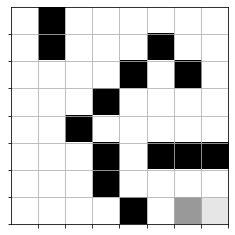

In [12]:
completion_check(model, qmaze)
show(qmaze)

This cell will test your model for one game. It will start the pirate at the top-left corner and run play_game. The agent should find a path from the starting position to the target (treasure). The treasure is located in the bottom-right corner.

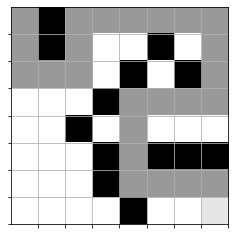

In [13]:
pirate_start = (0, 0)
play_game(model, qmaze, pirate_start)
show(qmaze)